
Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 6 Predicting Stock Prices with Artificial Neural Networks

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)


# Predicting stock prices with neural networks 

## Training a simple neural network 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

In [2]:
# Reusing the feature generation function we developed
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adj Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new


In [3]:
data_raw = pd.read_csv('19900101_20230630.csv', index_col='Date')
data = generate_features(data_raw)

start_train = '1990-01-01'
end_train = '2022-12-31'

start_test = '2023-01-01'
end_test = '2023-06-30'

data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

In [4]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [5]:
X_train_torch = torch.from_numpy(X_scaled_train.astype(np.float32))
X_test_torch = torch.from_numpy(X_scaled_test.astype(np.float32))
y_train = y_train.reshape(y_train.shape[0], 1)
y_train_torch = torch.from_numpy(y_train.astype(np.float32))

In [6]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 32),
                      nn.ReLU(),
                      nn.Linear(32, 1))

In [7]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)

In [8]:
def train_step(model, X_train, y_train, loss_function, optimizer):
    pred_train = model(X_train)
    loss = loss_function(pred_train, y_train)
 
    model.zero_grad()
    loss.backward()

    optimizer.step()
    
    return loss.item()

In [9]:
for epoch in range(1000):
    loss = train_step(model, X_train_torch, y_train_torch, loss_function, optimizer)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} - loss: {loss}")
        

Epoch 0 - loss: 24823446.0
Epoch 100 - loss: 189974.171875
Epoch 200 - loss: 52102.01171875
Epoch 300 - loss: 17849.333984375
Epoch 400 - loss: 8928.6689453125
Epoch 500 - loss: 6497.75927734375
Epoch 600 - loss: 5670.634765625
Epoch 700 - loss: 5265.48828125
Epoch 800 - loss: 5017.7021484375
Epoch 900 - loss: 4834.28466796875


In [10]:
predictions = model(X_test_torch).detach().numpy()[:, 0]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')


MSE: 30051.643
MAE: 137.096
R^2: 0.954


## Fine-tuning the neural network 

In [11]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
hparams_config = {
    "hidden_size": [16, 32],
    "epochs": [1000, 3000],
    "lr": [0.1, 0.3],
}

In [13]:
def train_validate_model(hidden_size, epochs, lr):
    model = nn.Sequential(nn.Linear(X_train.shape[1], hidden_size),
                                  nn.ReLU(),
                                  nn.Linear(hidden_size, 1))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create the TensorBoard writer
    writer_path = f"runs/{experiment_num}/{hidden_size}/{epochs}/{lr}"
    writer = SummaryWriter(log_dir=writer_path)

    for epoch in range(epochs):
        loss = train_step(model, X_train_torch, y_train_torch, loss_function, optimizer)

        predictions = model(X_test_torch).detach().numpy()[:, 0]
        test_mse = mean_squared_error(y_test, predictions)

        writer.add_scalar(
            tag="train loss",
            scalar_value=loss,
            global_step=epoch,
        )
        writer.add_scalar(
            tag="test loss",
            scalar_value=test_mse,
            global_step=epoch,
        )

    test_r2 = r2_score(y_test, predictions)
    print(f'R^2: {test_r2:.3f}\n')

    # Add the hyperparameters and metrics to TensorBoard
    writer.add_hparams(
        {
            "hidden_size": hidden_size,
            "epochs": epochs,
            "lr": lr,
        },
        {
            "test MSE": test_mse,
            "test R^2": test_r2,
        },
    )

In [14]:
experiment_num = 0

torch.manual_seed(42)
for hidden_size in hparams_config["hidden_size"]:
    for epochs in hparams_config["epochs"]:
        for lr in hparams_config["lr"]:
            experiment_num += 1
            print(f"Experiment {experiment_num}: hidden_size = {hidden_size}, epochs = {epochs}, lr = {lr}")
            train_validate_model(hidden_size, epochs, lr)
            

Experiment 1: hidden_size = 16, epochs = 1000, lr = 0.1
R^2: 0.771

Experiment 2: hidden_size = 16, epochs = 1000, lr = 0.3
R^2: 0.952

Experiment 3: hidden_size = 16, epochs = 3000, lr = 0.1
R^2: 0.969

Experiment 4: hidden_size = 16, epochs = 3000, lr = 0.3
R^2: 0.977

Experiment 5: hidden_size = 32, epochs = 1000, lr = 0.1
R^2: 0.877

Experiment 6: hidden_size = 32, epochs = 1000, lr = 0.3
R^2: 0.957

Experiment 7: hidden_size = 32, epochs = 3000, lr = 0.1
R^2: 0.970

Experiment 8: hidden_size = 32, epochs = 3000, lr = 0.3
R^2: 0.959



In [15]:
hidden_size = 16
epochs = 3000
lr = 0.3
best_model = nn.Sequential(nn.Linear(X_train.shape[1], hidden_size),
                           nn.ReLU(),
                           nn.Linear(hidden_size, 1))
optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)
for epoch in range(epochs):
    train_step(best_model, X_train_torch, y_train_torch, loss_function, optimizer)

predictions = best_model(X_test_torch).detach().numpy()[:, 0] 

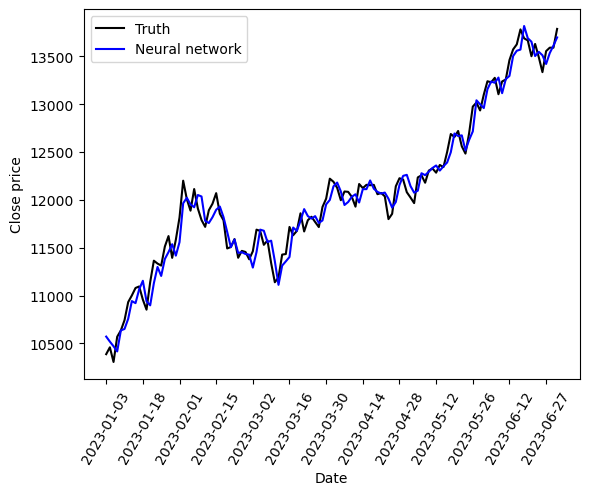

In [16]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.xticks(range(0, 130, 10), rotation=60)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close price', fontsize=10)
plt.legend(['Truth', 'Neural network'], fontsize=10)
plt.show()

---

Readers may ignore the next cell.

In [17]:
!jupyter nbconvert --to python ch6_part2.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch6_part2.ipynb to python
[NbConvertApp] Writing 8550 bytes to ch6_part2.py
